# Creating a BERT-like transformer



## The BERT

### General architecture

The BERT model consists of multiple transformer layers, where each layer is composed of multi-head self-attention and point-wise feedforward networks. The input to the model is a sequence of word-piece tokens, which are first passed through an embedding layer to generate dense vector representations of each token. These embeddings are then fed to the input of the first transformer layer. The output of the last transformer layer is then used as input to a task-specific layer, which can be a simple linear layer for classification tasks or a sequence labeling layer for sequence tagging tasks, among others.

The following are the contents of a single BERT transformer layer:

1. Multi-Head Self-Attention: This sublayer consists of multiple parallel attention mechanisms (heads) that attend to different parts of the input sequence. The output of each head is concatenated and then passed through a linear projection to produce a single attention vector for each input token.

2. Layer Normalization: This sublayer normalizes the outputs of the self-attention sublayer across the hidden dimension. Specifically, it applies a normalization operation that scales and shifts the outputs to have zero mean and unit variance.

3. Point-wise Feedforward Network: This sublayer applies a fully connected feedforward network to each position in the sequence independently. The output of this sublayer is a new set of hidden representations for each position.

4. Another Layer Normalization: As in step 2, this sublayer normalizes the outputs of the feedforward sublayer across the hidden dimension.

5. Skip Connection and Residual Connection: This sublayer adds the output of the feedforward sublayer to the original input embeddings and applies a residual connection. This allows the model to directly incorporate the original input embeddings into the final output of the layer.

Note that the output of each transformer layer is a sequence of hidden representations that are passed to the next layer in the stack. In BERT, multiple transformer layers are stacked on top of each other to form a deep neural network. The final output of the BERT model is typically the output of the last transformer layer, which can be used for downstream tasks such as text classification, named entity recognition, and question answering.

### Differences between the BERT and the original transformer

BERT (Bidirectional Encoder Representations from Transformers) is a variation of the original "Attention is All You Need" transformer model. The core idea behind both models is the same, i.e., to use self-attention to model the relationships between different positions in a sequence. However, BERT introduces several key modifications to the original transformer architecture that make it more effective for tasks such as natural language understanding.

The original transformer was designed as an encoder-decoder model for machine translation, where the encoder takes in the source language sentence and produces a sequence of hidden states, and the decoder takes in these hidden states and generates the target language sentence. However, BERT is not an encoder-decoder model like the original transformer.

Instead, BERT is an encoder-only model that is pre-trained on large amounts of unlabeled text data. The pre-training involves masking a certain percentage of the input tokens in each training example and training the model to predict the masked tokens based on the context provided by the other tokens in the input. 


### Positional encoding

The positional encoding (PE) scheme used in BERT is the same as the original transformer model, but there is a subtle difference in how the PE vectors are calculated. In the original transformer model, the PE vectors are calculated based on a fixed function that is defined separately from the model itself. Specifically, for each position in the input sequence, the PE vector is calculated based on a fixed set of sinusoidal functions with different frequencies and phases. The frequencies and phases are pre-defined and do not change during training.

In contrast, in BERT, the PE vectors are learned during the model training process. Specifically, the PE vectors are initialized randomly and then fine-tuned along with the rest of the model parameters during the pre-training process. This allows the model to learn a more task-specific representation of the position information that is optimal for the downstream task.

Another difference between BERT and the original transformer in terms of positional encoding is the way in which the position information is combined with the token embeddings. In the original transformer, the PE vectors are added directly to the token embeddings, while in BERT, the PE vectors are added after the token embeddings are passed through a layer normalization step. This means that the PE vectors in BERT have access to the normalized embeddings, which can help to mitigate the effect of covariate shift during training.

## Loading the data

Loading the data is the first step in any data-driven machine learning project. In this case, we will use the Python pandas library to read in the training and validation data from their respective CSV files using the ``pd.read_csv()`` function. The data is expected to be stored in the specified file locations relative to the current working directory.

In [1]:
import pandas as pd

df_train = pd.read_csv("../../data/train.csv", index_col=0)
df_validation = pd.read_csv("../../data/validation.csv", index_col=0)


## Creating the embeddings

First thing to do is to create our own embeddings and the embedding layer.

### Creating the vocabulary

In order to use an embedding layer, we'll first need to create our own vocabulary. This involves tokenizing our text data into a sequence of tokens and assigning a unique index to each token in the vocabulary. Creating the vocabulary is an important step in any natural language processing (NLP) project. In this case, we will create a vocabulary from the training data that will be used to convert the text into a numerical format that can be fed into the BERT model.

Next we extract the unique tokens from the training data and create a vocabulary for use in the BERT model. The resulting vocabulary will be used to map each word in the text data to a unique numerical ID, which will be used as input to the BERT model.

In [2]:
unique_tokens = set()
for i, row in df_train.iterrows():
    tokens = row["transcription"].split(" ")
    for token in tokens:
        unique_tokens.add(token)

print(f"Unique tokens: {len(unique_tokens)}")
unique_tokens = list(unique_tokens)

unique_tokens[:25]


Unique tokens: 18143


['nasopharyngoscopy',
 'rosenmuller',
 'diagnostic',
 'pursuit',
 'strengthened',
 '20l',
 'hyperhidrosis',
 '72',
 'reoccurrence',
 'bike',
 'derived',
 'design',
 'sulfate',
 'orifice',
 'adiposity',
 'indicator',
 'lab',
 'gained',
 'qam',
 'reducer',
 'adenomatous',
 'hemodilutional',
 'tibiales',
 'rf',
 'decrescendo']

Next we will create a mapping from each unique token to a unique integer ID, which will be used to represent the token in the numerical format. 

We start by defining several special tokens that are commonly used in NLP tasks, including the classification token ``[CLS]``, the separator token ``[SEP]``, the unknown token ``[UNK]``, and the padding token ``[PAD]``. These tokens will be added to the beginning of the vocabulary along with the unique tokens extracted from the training data.

In [3]:
cls_token = "[CLS]"
sep_token = "[SEP]"
unknown_token = "[UNK]"
padding_token = "[PAD]"
vocabulary = {}
idx = 0
tokens = [cls_token, sep_token, unknown_token, padding_token] + unique_tokens
for token in tokens:
    vocabulary[token] = idx
    idx += 1


### Mapping tokens to indices

Next, we will map each token in the text data to its corresponding index in the vocabulary. To achieve this, we will define two functions.

 - ``map_token_to_vocabulary_index()``: takes a single token as input and returns the index of the token in the vocabulary dictionary. If the token is not present in the vocabulary, the function returns the index of the unknown token ``[UNK]``.

 - ``map_seq_to_vocabulary()``: takes a string of text as input, splits it into individual tokens, and applies the ``map_token_to_vocabulary_index()`` function to each token using the built-in ``map()`` function. This function returns a list of vocabulary indices corresponding to each token in the input text.

These functions rely on the ``vocabulary`` dictionary that was created in the previous step, which maps each token to a unique numerical ID. The resulting list of vocabulary indices can be used as input to the BERT model, where each index corresponds to a particular token in the input text.

This step is important as it allows us to convert the raw text data into a numerical format that can be fed into the BERT model. The resulting numerical sequences will be used as input to the BERT model during both the pre-training and fine-tuning stages.

In [4]:
def map_token_to_vocabulary_index(token: str):
    try:
        idx = vocabulary[token]
    except KeyError:
        idx = vocabulary[unknown_token]
    return idx


def map_seq_to_vocabulary(text: str):
    tokens = text.split(" ")
    return list(map(map_token_to_vocabulary_index, tokens))


Using these functions, we will create new columns in the pandas DataFrame objects to store the resulting numerical indices. After running this code, the ``df_train`` and ``df_validation`` DataFrames will contain a new column called ``idx_labels``, which stores the numerical indices for each row of text data. 

In [5]:
df_train["idx_labels"] = df_train["transcription"].apply(map_seq_to_vocabulary)
df_validation["idx_labels"] = df_validation["transcription"].apply(
    map_seq_to_vocabulary
)


### Padding and trimming to max length

The next step is to prepare the numerical sequences of token indices for input to the BERT model. To do this, we will define a function that will trim or pad each sequence to a fixed maximum length.

This function is important as it allows us to ensure that each input sequence to the BERT model has the same length, which is required for efficient batch processing during training. By trimming or padding each sequence to a fixed length, we can ensure that all sequences can be processed efficiently in parallel by the BERT model.

In [6]:
# Don't remove this cell
MAX_LEN = 128


The function, called ``trim_or_pad()``, takes a list of numerical indices as input and performs the following operations:

1. Inserts the index of the classification token ``[CLS]`` at the beginning of the sequence.
1. If the sequence length is greater than the maximum length ``MAX_LEN``, it trims the sequence to the maximum length by discarding tokens from the end of the sequence.
1. Replaces the last token in the sequence with the index of the separator token ``[SEP].``
1. If the sequence length is less than the maximum length, it pads the sequence with the index of the padding token ``[PAD]`` to the maximum length.
1. The ``MAX_LEN`` parameter is a fixed maximum sequence length that we have chosen for the BERT model. Any sequences longer than ``MAX_LEN`` will be trimmed, and any sequences shorter than ``MAX_LEN`` will be padded.

In [7]:
def trim_or_pad(indices: list):
    cls_idx = vocabulary[cls_token]
    indices.insert(0, cls_idx)

    if len(indices) > MAX_LEN:
        indices = indices[:MAX_LEN]

    sep_idx = vocabulary[sep_token]
    indices[-1] = sep_idx

    padding_idx = vocabulary[padding_token]
    if len(indices) < MAX_LEN:
        padding = MAX_LEN - len(indices)
        indices = indices + [padding_idx] * padding

    return indices


In [8]:
df_train["idx_labels"] = df_train["idx_labels"].apply(trim_or_pad)
df_validation["idx_labels"] = df_validation["idx_labels"].apply(trim_or_pad)
df_train["idx_labels"].head()


204     [0, 12033, 6580, 8336, 15449, 6867, 3210, 1138...
1561    [0, 15080, 7934, 16750, 5923, 13737, 13427, 10...
1564    [0, 15080, 7934, 9839, 14576, 12373, 5931, 138...
1072    [0, 12033, 6580, 16750, 4925, 8646, 7747, 2161...
4193    [0, 7007, 5422, 1780, 6709, 9081, 9178, 5931, ...
Name: idx_labels, dtype: object

After mapping the tokens to their corresponding indices in the vocabulary and applying padding and trimming to the sequences, we have now prepared our data to be fed into the BERT model.

### Padding mask

The last part of modifying our data for embedding is to generate a mask for informing the model about padded values. This is similar to how the BERT we used in the first workshop has been implemented.

In [9]:
padding_idx = vocabulary[padding_token]
df_train["attention_mask"] = df_train["idx_labels"].apply(
    lambda tokens: [token != padding_idx for token in tokens]
)
df_validation["attention_mask"] = df_validation["idx_labels"].apply(
    lambda tokens: [token != padding_idx for token in tokens]
)


<Axes: >

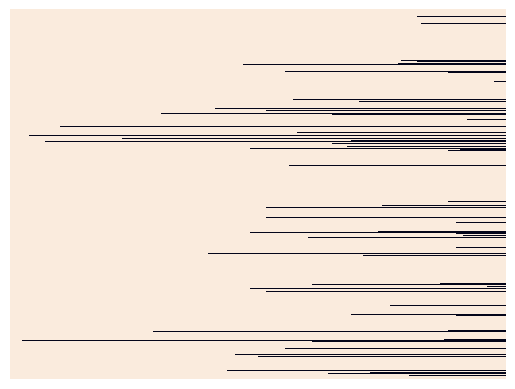

In [10]:
import seaborn as sns
import numpy as np

mask_arr = np.array(df_train.iloc[:, -1:].values.tolist()).squeeze(1)
sns.heatmap(mask_arr, cbar=False, xticklabels=[], yticklabels=[])


### Embedding layer

In [11]:
import torch
import torch.nn as nn


class TranscriptionEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(TranscriptionEmbedding, self).__init__()
        padding_idx = vocabulary[padding_token]
        self.embedding = nn.Embedding(
            vocab_size, embedding_dim, padding_idx=padding_idx
        )

    def forward(self, x):
        x = self.embedding(x)
        return x


In [12]:
embedding = TranscriptionEmbedding(vocab_size=len(vocabulary), embedding_dim=64)
sample = torch.tensor(df_train["idx_labels"].values[0])
embedded_sample = embedding(sample)
print(f"Embedding output shape: {embedded_sample.shape}")
embedded_sample


Embedding output shape: torch.Size([128, 64])


tensor([[-8.2848e-01, -2.3622e-01, -8.6701e-01,  ...,  9.9628e-01,
          3.9725e-01, -2.8840e-01],
        [ 1.2859e-01, -4.9964e-01, -1.1247e+00,  ...,  5.8802e-01,
         -8.2757e-01, -3.3755e-02],
        [-1.6918e+00, -3.5186e-06, -1.7359e+00,  ..., -8.5207e-01,
         -8.4908e-01,  5.2583e-01],
        ...,
        [ 3.9337e-01, -9.7914e-01, -1.3223e+00,  ...,  2.2692e+00,
          6.1488e-01,  1.2311e+00],
        [ 3.6993e-01, -5.7487e-01, -1.7773e+00,  ..., -9.2903e-01,
          1.1926e+00, -2.0399e-01],
        [ 1.3671e+00, -2.9186e-01,  5.0808e-01,  ...,  3.6067e-01,
          7.9539e-01,  8.4303e-01]], grad_fn=<EmbeddingBackward0>)

## Creating the BERT-like transformer

### Positional Encoding

In [13]:
import math
import torch
import torch.nn as nn


class PositionalEncoding(nn.Module):
    def __init__(self, hidden_size, max_len=512):
        super().__init__()

        # Compute the positional encodings once in log space
        pe = torch.zeros(max_len, hidden_size)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, hidden_size, 2).float() * (-math.log(10000.0) / hidden_size)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        # Add the positional encoding to the input embeddings
        x = x + self.pe[:, : x.size(1)]
        return x


This implementation computes the positional encodings using a formula based on sine and cosine functions. The positional encodings are then added to the input embeddings in the ``forward()`` method of the module.

### Multi-head attention

In [14]:
import torch
import torch.nn as nn


class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads

        # Linear projections
        self.query_linear = nn.Linear(hidden_size, hidden_size)
        self.key_linear = nn.Linear(hidden_size, hidden_size)
        self.value_linear = nn.Linear(hidden_size, hidden_size)

        # Output projection
        self.output_linear = nn.Linear(hidden_size, hidden_size)

    def forward(self, input_tensor, attention_mask=None):
        batch_size, seq_length, hidden_size = input_tensor.size()

        # Project inputs to queries, keys, and values
        query = self.query_linear(input_tensor)
        key = self.key_linear(input_tensor)
        value = self.value_linear(input_tensor)

        # Split heads
        query = query.view(
            batch_size, seq_length, self.num_heads, hidden_size // self.num_heads
        )
        key = key.view(
            batch_size, seq_length, self.num_heads, hidden_size // self.num_heads
        )
        value = value.view(
            batch_size, seq_length, self.num_heads, hidden_size // self.num_heads
        )

        # Transpose to get dimensions [batch_size, num_heads, seq_length, hidden_size // num_heads]
        query = query.transpose(1, 2)
        key = key.transpose(1, 2)
        value = value.transpose(1, 2)

        # Compute attention scores
        scores = torch.matmul(query, key.transpose(-2, -1))
        scores = scores / (hidden_size // self.num_heads) ** 0.5

        if attention_mask is not None:
            scores = scores.masked_fill(attention_mask.unsqueeze(1).unsqueeze(2), -1e9)

        # Apply softmax to obtain attention weights
        weights = nn.Softmax(dim=-1)(scores)

        # Apply attention weights to values
        context = torch.matmul(weights, value)

        # Concatenate heads and apply output projection
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_length, -1)
        output = self.output_linear(context)

        return output


This module takes an input tensor of shape ``(batch_size, seq_length, hidden_size)`` and applies multi-head self-attention to the input. The ``hidden_size`` parameter determines the dimensionality of the input and output tensors, and the ``num_heads`` parameter determines the number of parallel attention mechanisms (heads) to use.

The module first projects the input tensor to query, key, and value vectors using linear projection layers. It then splits the query, key, and value vectors into multiple heads using the ``view()`` method and transposes the resulting tensor so that the head dimension comes before the sequence and hidden dimensions.

The module then computes attention scores by taking the dot product of the query and key tensors, scaling the result by the square root of the hidden size, and applying a mask to the scores to prevent attending to padding tokens. The module applies a softmax function to the attention scores along the head and sequence dimensions to obtain attention weights for each token in the sequence.

The module then multiplies the attention weights by the value vectors, concatenates the resulting tensor along the head dimension, and passes the result through a linear projection layer to obtain the output tensor.

Let's see how the multi-head attention module is used.

In [15]:
sample = torch.tensor([df_train["idx_labels"].values[0]])
print(f"Input sample: {sample.shape}")

mask = torch.tensor([df_train["attention_mask"].values[0]])
print(f"Input mask: {mask.shape}")

embedding = TranscriptionEmbedding(vocab_size=len(vocabulary), embedding_dim=64)
attention = MultiHeadAttention(hidden_size=64, num_heads=4)

embedded_sample = embedding(sample)
print(f"Embedded input sample: {embedded_sample.shape}")

output = attention(embedded_sample, mask)
print(f"Multi-head attention output: {output.shape}")
output


Input sample: torch.Size([1, 128])
Input mask: torch.Size([1, 128])
Embedded input sample: torch.Size([1, 128, 64])
Multi-head attention output: torch.Size([1, 128, 64])


tensor([[[-0.0128,  0.0018, -0.0713,  ...,  0.0845, -0.0837,  0.0134],
         [-0.0128,  0.0018, -0.0713,  ...,  0.0845, -0.0837,  0.0134],
         [-0.0128,  0.0018, -0.0713,  ...,  0.0845, -0.0837,  0.0134],
         ...,
         [-0.0128,  0.0018, -0.0713,  ...,  0.0845, -0.0837,  0.0134],
         [-0.0128,  0.0018, -0.0713,  ...,  0.0845, -0.0837,  0.0134],
         [-0.0128,  0.0018, -0.0713,  ...,  0.0845, -0.0837,  0.0134]]],
       grad_fn=<ViewBackward0>)

### Transformer layer

In [16]:
import torch
import torch.nn as nn


class TransformerLayer(nn.Module):
    def __init__(self, hidden_size, num_heads, ff_size):
        super().__init__()
        self.multihead_attention = MultiHeadAttention(hidden_size, num_heads)
        self.layer_norm1 = nn.LayerNorm(hidden_size)
        self.pointwise_feedforward = nn.Sequential(
            nn.Linear(hidden_size, ff_size),
            nn.Linear(ff_size, hidden_size),
            nn.ReLU(),
        )
        self.layer_norm2 = nn.LayerNorm(hidden_size)

    def forward(self, x, attention_mask=None):
        attention_output = self.multihead_attention(x, attention_mask)
        norm1_output = self.layer_norm1(x + attention_output)
        ff_output = self.pointwise_feedforward(norm1_output)
        norm2_output = self.layer_norm2(norm1_output + ff_output)
        return norm2_output


The ``TransformerLayer`` module takes an input tensor ``x`` of shape ``(batch_size, seq_length, hidden_size)`` and an optional padding mask ``attention_mask`` of shape ``(batch_size, seq_length)``. 

It first applies the multi-head self-attention sublayer to the input tensor, passing the padding mask as an additional argument. It then applies the first layer normalization sublayer, adds the output of the multi-head self-attention sublayer to the input tensor using a skip connection, and applies the second layer normalization sublayer. Finally, it passes the output through the point-wise feedforward sublayer and adds the resulting tensor to the output of the second layer normalization sublayer using another skip connection.

Let's see the layer in action, too.

In [17]:
sample = torch.tensor([df_train["idx_labels"].values[0]])
mask = torch.tensor([df_train["attention_mask"].values[0]])

embedding = TranscriptionEmbedding(vocab_size=len(vocabulary), embedding_dim=64)
transformer_layer = TransformerLayer(hidden_size=64, num_heads=4, ff_size=128)

embedded_sample = embedding(sample)
output = transformer_layer(embedded_sample, mask)
print(f"Transformer layer output: {output.shape}")
output


Transformer layer output: torch.Size([1, 128, 64])


tensor([[[-0.1997, -0.9157, -0.4273,  ..., -0.7983, -0.6273, -0.1647],
         [-2.3000,  0.3583, -1.1448,  ...,  0.4278,  0.2942, -0.6848],
         [ 1.4600,  0.0072, -1.7019,  ...,  0.2434,  1.7239, -0.4886],
         ...,
         [-1.3621, -0.7635, -0.2736,  ...,  1.3146, -1.0958, -0.4531],
         [-1.0960, -1.3660,  0.3684,  ...,  0.2475,  0.1249,  1.3666],
         [ 0.8116,  2.5123, -1.0757,  ..., -0.9678, -1.4988, -1.2642]]],
       grad_fn=<NativeLayerNormBackward0>)

### BERT-like transformer

In this implementation, we create an instance of the BERT module with the following hyperparameters:

- ``vocab_size``: The size of the vocabulary for the input sequence.
- ``hidden_size``: The dimensionality of the input and output tensors.
- ``num_layers``: The number of transformer layers to stack.
- ``num_heads``: The number of parallel attention mechanisms to use in each transformer layer.
- ``ff_size``: The size of the feedforward network used in each transformer layer.
- ``max_len``: The maximum length of the input sequence.

We first create an input embedding layer using ``TranscriptionEmbedding``. We then create a ``PositionalEncoding`` module that adds position information to the input embeddings.

We then create a stack of transformer layers using ``nn.ModuleList`` and the ``TransformerLayer`` module. We also create an output layer for classification using ``nn.Linear``.

In the ``forward()`` method, we first apply the input embedding and positional encoding to the input tensor. We then apply each of the transformer layers in turn. Finally, we apply the classification layer to the output tensor, using only the first token (the ``[CLS]`` token) for classification.

Note that this implementation is simplified and does not include all of the features of a full BERT model. For example, BERT includes a separate output layer for each token in the input sequence, and uses a more complex classification scheme than the simple linear layer used here. However, this implementation should give you an idea of how to use the ``TransformerLayer`` module to create a BERT-like architecture.

In [18]:
import torch
import torch.nn as nn


class BERT(nn.Module):
    def __init__(
        self,
        vocab_size,
        num_classes,
        hidden_size=768,
        num_layers=12,
        num_heads=12,
        ff_size=3072,
        max_len=512,
    ):
        super().__init__()

        self.embedding = TranscriptionEmbedding(vocab_size, hidden_size)
        self.positional_encoding = PositionalEncoding(hidden_size, max_len)
        self.transformer_layers = nn.ModuleList(
            [
                TransformerLayer(hidden_size, num_heads, ff_size)
                for _ in range(num_layers)
            ]
        )
        self.classifier = nn.Linear(hidden_size, num_classes)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask=None, labels=None):
        x = self.embedding(input_ids)
        x = self.positional_encoding(x)
        for transformer_layer in self.transformer_layers:
            x = transformer_layer(x, attention_mask)
        x = self.classifier(x[:, 0, :])  # use the first token for classification
        if labels is not None:
            loss = self.loss(x, labels)
            return {"loss": loss, "logits": x}
        return {"logits": x}


## Training the BERT-like transformer

### Defining target values

In [19]:
class_to_label = {
    "Surgery": 0,
    "Radiology": 1,
    "Consult": 2,
    "Cardiovascular": 3,
    "Orthopedic": 4,
    "General Medicine": 5,
}
df_train["medical_specialty_label"] = df_train["medical_specialty"].map(class_to_label)
df_validation["medical_specialty_label"] = df_validation["medical_specialty"].map(
    class_to_label
)

df_train["medical_specialty_label"].head()


204     0
1561    1
1564    1
1072    0
4193    2
Name: medical_specialty_label, dtype: int64

### Defining a classification dataset

In [20]:
import torch


class MedicalTranscriptionDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.tokens = torch.tensor(df["idx_labels"].values.tolist()).long()
        self.attention_mask = torch.tensor(df["attention_mask"].values.tolist())
        self.labels = torch.tensor(df["medical_specialty_label"].values.tolist())

    def __getitem__(self, idx):
        return {
            "input_ids": self.tokens[idx].clone().detach(),
            "attention_mask": self.attention_mask[idx].clone().detach(),
            "labels": self.labels[idx].clone().detach(),
        }

    def __len__(self):
        return len(self.tokens)


In [21]:
dataset = MedicalTranscriptionDataset(df=df_train)
sample = dataset[1]
print(f"Sample type: {type(sample)}")
print(f"Sample keys: {sample.keys()}")
sample


Sample type: <class 'dict'>
Sample keys: dict_keys(['input_ids', 'attention_mask', 'labels'])


{'input_ids': tensor([    0, 15080,  7934, 16750,  5923, 13737, 13427, 10261,  3231,  5931,
         13957, 16535,  8749, 13012,  2310,  3077, 14975,  1906,  6335, 14576,
          7545, 14585,  6387, 11809, 17659, 13725, 13766, 11421,  4033, 15168,
          8180,  7177,  9654,  9686, 13925,  1180,  6306,  9686, 16068,  2806,
          6306,  5049, 17842,  3136,  9548, 15371,  6306,  2366, 14773,  2515,
          6335,  3488,  1236,  6306,  5025,   350, 14881,  6387, 17460,  2806,
          1196, 16118,  4033, 15168,  8180,  7177,  5613,  4033,  6235,  8180,
         10989,  7952, 15027,  5533,  3220,  9404,  6922, 17832,  4939, 16459,
         17320, 14773, 12935,  4033,  6235,  8180,  2997, 11941,  3618, 15027,
         13375,  9539, 11041, 11529, 11126,  3114, 11291,  1518,  1386, 16196,
          8564,  3776, 11832,   447,  4033, 17765,  8180, 10989, 14141,  4033,
          6235,  8180,  1018, 12369,  9548, 13375,  9056, 14786, 16854, 10594,
          8536, 15492, 15356, 15492, 16

In [22]:
model = BERT(
    vocab_size=len(vocabulary),
    num_classes=len(df_train["medical_specialty_label"].unique()),
    hidden_size=64,
    num_layers=4,
    num_heads=4,
    ff_size=128,
    max_len=MAX_LEN,
)
model(
    input_ids=sample["input_ids"].unsqueeze(0),
    attention_mask=sample["attention_mask"].unsqueeze(0),
    labels=sample["labels"].unsqueeze(0),
)


{'loss': tensor(1.6430, grad_fn=<NllLossBackward0>),
 'logits': tensor([[-0.1910,  0.1175,  0.1654, -0.0849, -0.2125, -0.0433]],
        grad_fn=<AddmmBackward0>)}

### Training the model

In [23]:
import os
from transformers import TrainingArguments, Trainer

torch.cuda.empty_cache()
trainer = Trainer(
    model=BERT(
        vocab_size=len(vocabulary),
        num_classes=len(df_train["medical_specialty_label"].unique()),
        hidden_size=256,
        num_layers=12,
        num_heads=8,
        ff_size=512,
        max_len=MAX_LEN,
    ),
    train_dataset=MedicalTranscriptionDataset(df=df_train),
    args=TrainingArguments(
        output_dir="out",
        per_device_train_batch_size=64,
        num_train_epochs=8,
        dataloader_num_workers=8,
    ),
)
trainer.train()
model_path = f"../../model/custom-bert/model.pt"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
# We'll save like any Pytorch model, as the model is not a Hugging Face `PreTrainedModel`
torch.save(trainer.model, model_path)


/home/grimfada/miniconda3/envs/transformers-seminar-workshop/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2290
  Num Epochs = 8
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 288
  Number of trainable parameters = 10972422


Step,Training Loss


## Evaluating the model

In [24]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


def compute_metrics(preds):
    y_true = preds.label_ids
    y_pred = preds.predictions.argmax(-1)
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="weighted", zero_division=0
    )
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


In [26]:
preds = trainer.predict(test_dataset=MedicalTranscriptionDataset(df=df_validation))
compute_metrics(preds=preds)


***** Running Prediction *****
  Num examples = 572
  Batch size = 8


{'accuracy': 0.5594405594405595,
 'precision': 0.48702118565027797,
 'recall': 0.5594405594405595,
 'f1': 0.503004396610791}